# 다중선형회귀 + 학습성능 개선

> 농어의 무게 예측 데이터 셋

텐서플로우의 학습성능을 개선하기 위해 아래의 기능을 사용할 수 있음

- 데이터 표준화: 학습률 향상에 도움을 줌
- 콜백함수: 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 설정 하기 위한 도구

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[scatterd] >WARNING> From c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



### [2] 데이터셋 준비하기

In [2]:
origin = my_read_excel('https://data.hossam.kr/mldata/fish.xlsx', info=False)

## #02. 데이터 전처리

### [1] 훈련/검증 데이터 분리

**데이터 정규화(스케일링)** 을 수행함

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다.

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, yname='무게', scalling=True)
rows, cols = x_train.shape
rows, cols

(44, 3)

## #03. 훈련 모델 적합

### [1] 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |

In [4]:
model = Sequential()
# 최종 검증 손실률: 169142.234375, 최종 검증 절대오차: 315.249176
# model.add(Dense(4, activation = 'relu', input_shape = (cols, )))
# model.add(Dense(2, activation = 'relu'))

# 최종 검증 손실률: 193492.796875, 최종 검증 절대오차: 347.600739
model.add(Dense(8, activation = 'relu', input_shape = (cols, )))
model.add(Dense(4, activation = 'relu'))

# ... (16, 8), (32, 16) 에 대한 테스트 결과는 생략함

# 최종 검증 손실률: 2974.242920, 최종 검증 절대오차: 36.543842
model.add(Dense(64, activation = 'relu', input_shape = (cols, )))
model.add(Dense(32, activation = 'relu'))

# 최종 검증 손실률: 4515.570801, 최종 검증 절대오차: 40.064499
# model.add(Dense(128, activation = 'relu', input_shape = (cols, )))
# model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

[scatterd] >WARNING> From c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

[scatterd] >WARNING> From c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 64)                320       
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2501 (9.77 KB)
Trainable params: 2501 (9.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 8, 4

최종 검증 손실률: 193492.796875, 최종 검증 절대오차: 347.600739

![img](res/fish-8,4.png)

#### 64, 32

최종 검증 손실률: 2974.242920, 최종 검증 절대오차: 36.543842

![img](res/fish-64,32.png)

#### 128, 64

최종 검증 손실률: 4515.570801, 최종 검증 절대오차: 40.064499

![img](res/fish-128,64.png)

### [2] 콜백함수를 적용하여 학습하기

모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 설정하기 위한 도구

#### 콜백함수 사용 방법

```python
# 콜백 정의
callbacks = [  콜백1, 콜백2, ... 콜백n  ]

# 학습을 위한 fit() 함수에서 callbacks 파라미터에 미리 정의한 리스트를 지정
callbacks = [콜백1, 콜백2, ... , 콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, 
        callbacks = callbacks)
```

혹은

```python
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, 
    callbacks = [
        콜백1, 콜백2, ... , 콜백n
])
```

#### 콜백함수 종류

##### 1) EarlyStopping()

모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 더 이상 성능 향상이 일어나지 않은 경우 학습을 스스로 중단

```python
EarlyStopping(monitor='평가지표', patience=10, verbose=1)
```

- patience: 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단 (기간이라 함은 에폭을 의미) 예를 들어 patience=10일 때, 10에폭 동안 성능 향상이 일어나지 않으면 학습을 중단. 즉, 10회 이상 성능향상이 발견되지 않으면 중단함
- verbose: 콜백의 수행 과정 노출 여부를 지정.
    - 0: 아무런 표시 하지 않음(기본값)
    - 1: 프로그래스바로 표시
    - 2: 매 에폭마다 수행과정을 자세하게 출력함.


##### 2) ReduceLROnPlateau()

EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백

```python
ReduceLROnPlateau(monitor='평가지표', factor=0.1, patience=10, min_lr=0, verbose=1)
```

- factor: 학습률 조정에 사용되는 값 (새로운 학습률 = factor * 기존 학습률)
- patience: 지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr: 학습률의 하한을 지정
- verbose: 콜백의 수행 과정 노출 여부를 지정.


##### 3) ModelCheckpoint()

지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

```python
ModelCheckpoint(filepath, monitor='평가지표', verbose=1, save_best_only=True|False, save_weights_only=False)
```

- filepath: 모델의 저장 경로를 지정
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 모델의 경우는 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장

In [5]:
%%time
# 파일이 저장될 경로(폴더) 지정 (한글,공백,점(.)이 포함되어 있을 경우 에러 발생함)
checkpoint_path = "D:\\tensorflow_checkpoint\\model04-cp-{epoch:04d}-ckpt.keras"

result = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500, verbose=0, callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=0),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.1, min_lr=0.0001, verbose=0),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
])

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

result_df = DataFrame(result.history)
result_df["epochs"] = result_df.index + 1
result_df.set_index('epochs', inplace=True)
result_df

[scatterd] >WARNING> From c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

[scatterd] >WARNING> From c:\Users\hyk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.




Epoch 1: val_loss improved from inf to 194172.01562, saving model to D:\tensorflow_checkpoint\model04-cp-0001-ckpt.keras

Epoch 2: val_loss improved from 194172.01562 to 194144.79688, saving model to D:\tensorflow_checkpoint\model04-cp-0002-ckpt.keras

Epoch 3: val_loss improved from 194144.79688 to 194116.92188, saving model to D:\tensorflow_checkpoint\model04-cp-0003-ckpt.keras

Epoch 4: val_loss improved from 194116.92188 to 194088.68750, saving model to D:\tensorflow_checkpoint\model04-cp-0004-ckpt.keras

Epoch 5: val_loss improved from 194088.68750 to 194061.12500, saving model to D:\tensorflow_checkpoint\model04-cp-0005-ckpt.keras

Epoch 6: val_loss improved from 194061.12500 to 194034.00000, saving model to D:\tensorflow_checkpoint\model04-cp-0006-ckpt.keras

Epoch 7: val_loss improved from 194034.00000 to 194005.25000, saving model to D:\tensorflow_checkpoint\model04-cp-0007-ckpt.keras

Epoch 8: val_loss improved from 194005.25000 to 193974.50000, saving model to D:\tensorflow

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,284073.125000,391.426453,194172.015625,348.555298,0.0010
2,284033.625000,391.379669,194144.796875,348.514923,0.0010
3,283998.375000,391.335144,194116.921875,348.474945,0.0010
4,283958.281250,391.289429,194088.687500,348.436066,0.0010
5,283924.375000,391.246613,194061.125000,348.397247,0.0010
...,...,...,...,...,...
136,6465.223633,62.324547,7812.450684,75.956032,0.0001
137,6439.582520,62.196255,7809.232910,75.950706,0.0001
138,6411.486328,62.053879,7804.833496,75.939705,0.0001


### [3] 훈련 결과 시각화

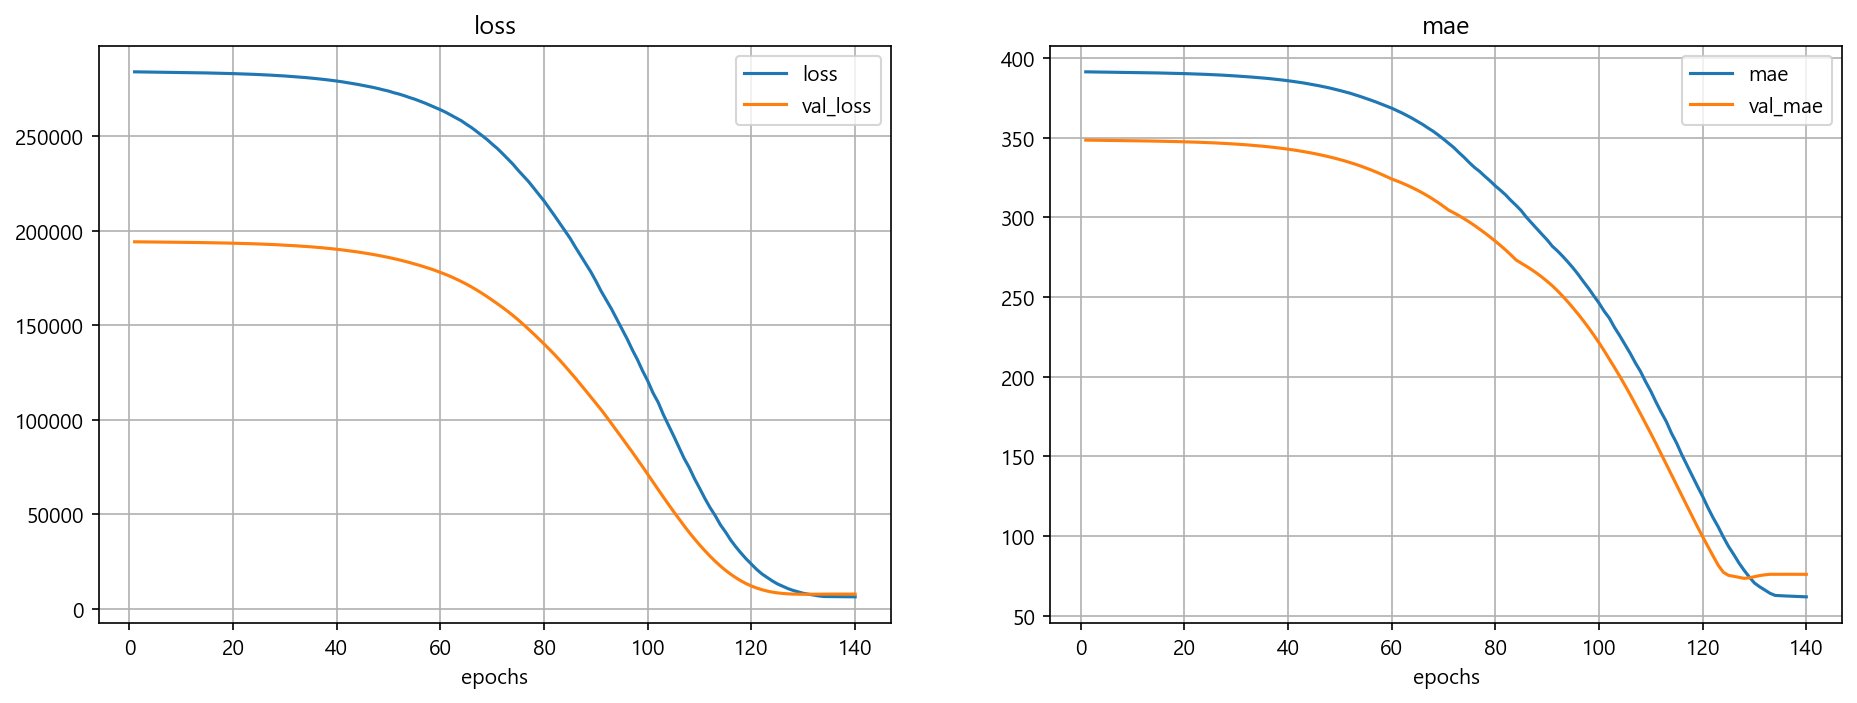

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
result_df.plot(y=['loss', 'val_loss'], ax=ax[0])
result_df.plot(y=['mae', 'val_mae'], ax=ax[1])
ax[0].set_title('loss')
ax[1].set_title('mae')
ax[0].grid()
ax[1].grid()
plt.show()
plt.close()

## #04. 예측 결과 활용

### [1] 예측치 구하기

In [7]:
pred =  model.predict(x_test, verbose=0)
pred

array([[743.6976 ],
       [176.72664],
       [722.47943],
       [146.45932],
       [173.9795 ],
       [215.76448],
       [152.48753],
       [680.25775],
       [920.52374],
       [272.02042],
       [192.4406 ],
       [166.9511 ]], dtype=float32)

### [2] 결과 데이터 셋 구성

In [8]:
kdf = DataFrame({
    '길이': x_test['길이'],
    '실제값': y_test,
    '예측값' : pred.flatten()
})

kdf['오차'] = kdf['실제값']-kdf['예측값']

my_pretty_table(kdf)

+----+------------+----------+----------+----------+
|    |       길이 |   실제값 |   예측값 |     오차 |
|----+------------+----------+----------+----------|
| 45 |    1.20816 |      650 |  743.698 | -93.6976 |
| 33 | -0.0476513 |      250 |  176.727 |  73.2734 |
| 40 |   0.935156 |      685 |  722.479 | -37.4794 |
| 26 |  -0.364334 |      188 |  146.459 |  41.5407 |
| 11 |  -0.757457 |      115 |   173.98 | -58.9795 |
|  2 |   -1.41266 |       40 |  215.764 | -175.764 |
| 32 | -0.0476513 |      265 |  152.488 |  112.512 |
| 43 |   0.989757 |      690 |  680.258 |  9.74225 |
| 46 |    1.20816 |      820 |  920.524 | -100.524 |
| 30 | -0.0694914 |      300 |   272.02 |  27.9796 |
|  4 |   -1.15058 |       70 |  192.441 | -122.441 |
| 10 |  -0.757457 |      110 |  166.951 | -56.9511 |
+----+------------+----------+----------+----------+


### [3] 관측치와 예측치 비교 시각화

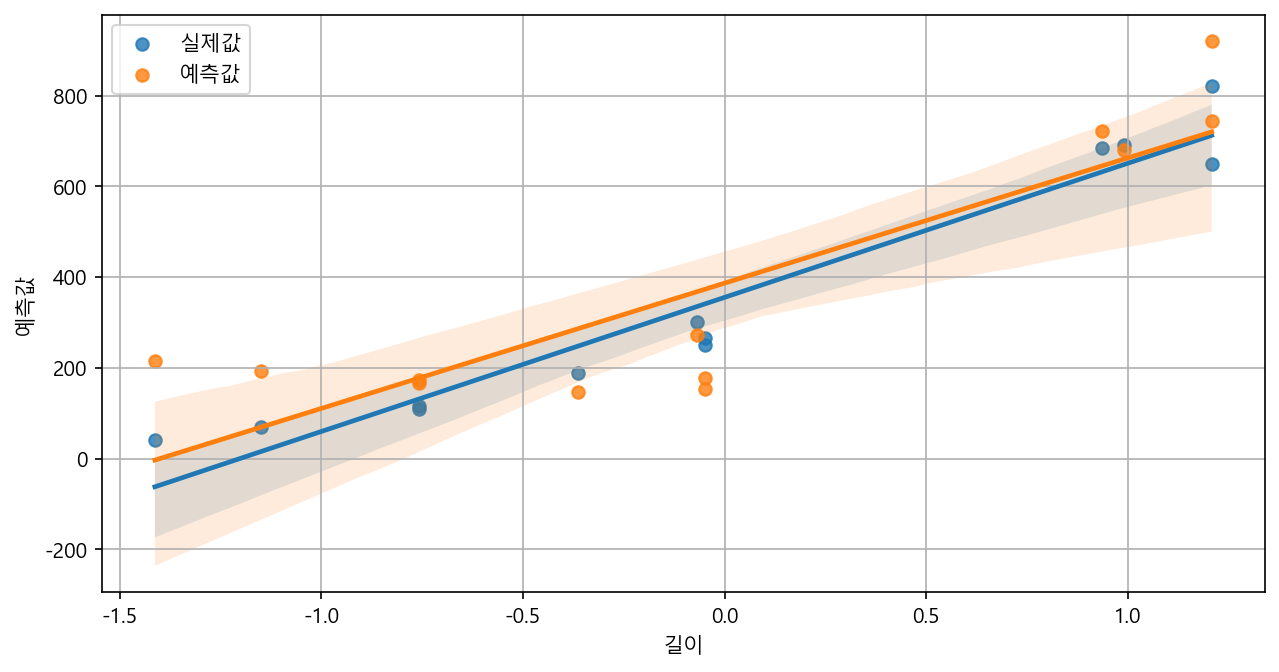

In [9]:
fig = plt.figure(figsize=(10, 5), dpi=150)
ax = fig.gca()

sb.regplot(data=kdf, x='길이', y='실제값', label='실제값', ax=ax)
sb.regplot(data=kdf, x='길이', y='예측값', label='예측값', ax=ax)
ax.legend()
ax.grid()
plt.show()
plt.close()